In [1]:
# Import Packages
import glob  # OS dependencies to get file system details'
import cv2
#importing some useful packages
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from ipywidgets import interact, interactive, fixed

%matplotlib inline

In [10]:
def show_images(images, gray=None, divider = 2):
    """
    This is an utility function to show multiple images with different colour maps

    :param images - An images list
    :param gray - A flag to set default value for matplotlib imshow colour map. If the image
                  shape is 2( i.e binary image) then cmap value will be "gray"
    :return: Nothing
    """
    rows = (len(images)+1)//divider
    plt.figure(figsize=(16, 16))
    for idx, img in enumerate(images):
        plt.subplot(rows, divider, idx+1)
        # if the image is binary then it'll be printed as grayscale, otherwise colour map
        # will be ignored
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else gray)
        plt.xticks([])
        plt.yticks([])

    plt.show()

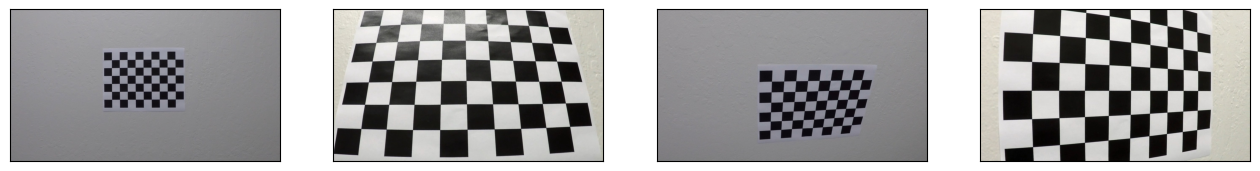

In [11]:
# Loading test images from test_image directory
camera_cal_imgs = [mpimg.imread(path) for path in glob.glob("canera_cal/*")]

# Visualize calibration images
show_images(camera_cal_imgs[:4], divider=4)

In [2]:
def grayscale(img, opencv_read=False):
    """

    :param img:
    :param opencv_read:
    :return:
    """
    if opencv_read:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


### Camera calibration
Camera resectioning determines which incoming light is associated with each pixel on the resulting image.

In [12]:
# prepare objects points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and iamg points from all the images
objpoints = []
imgpoints = []

def find_and_draw_chessboard(img, pattern_size= (9,6)):
    gray = grayscale(img)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    # if found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw and display the corners
        cv2.drawChessboardCorners(img, pattern_size, corners, ret)
    
    # if not found, return same input image
    return img

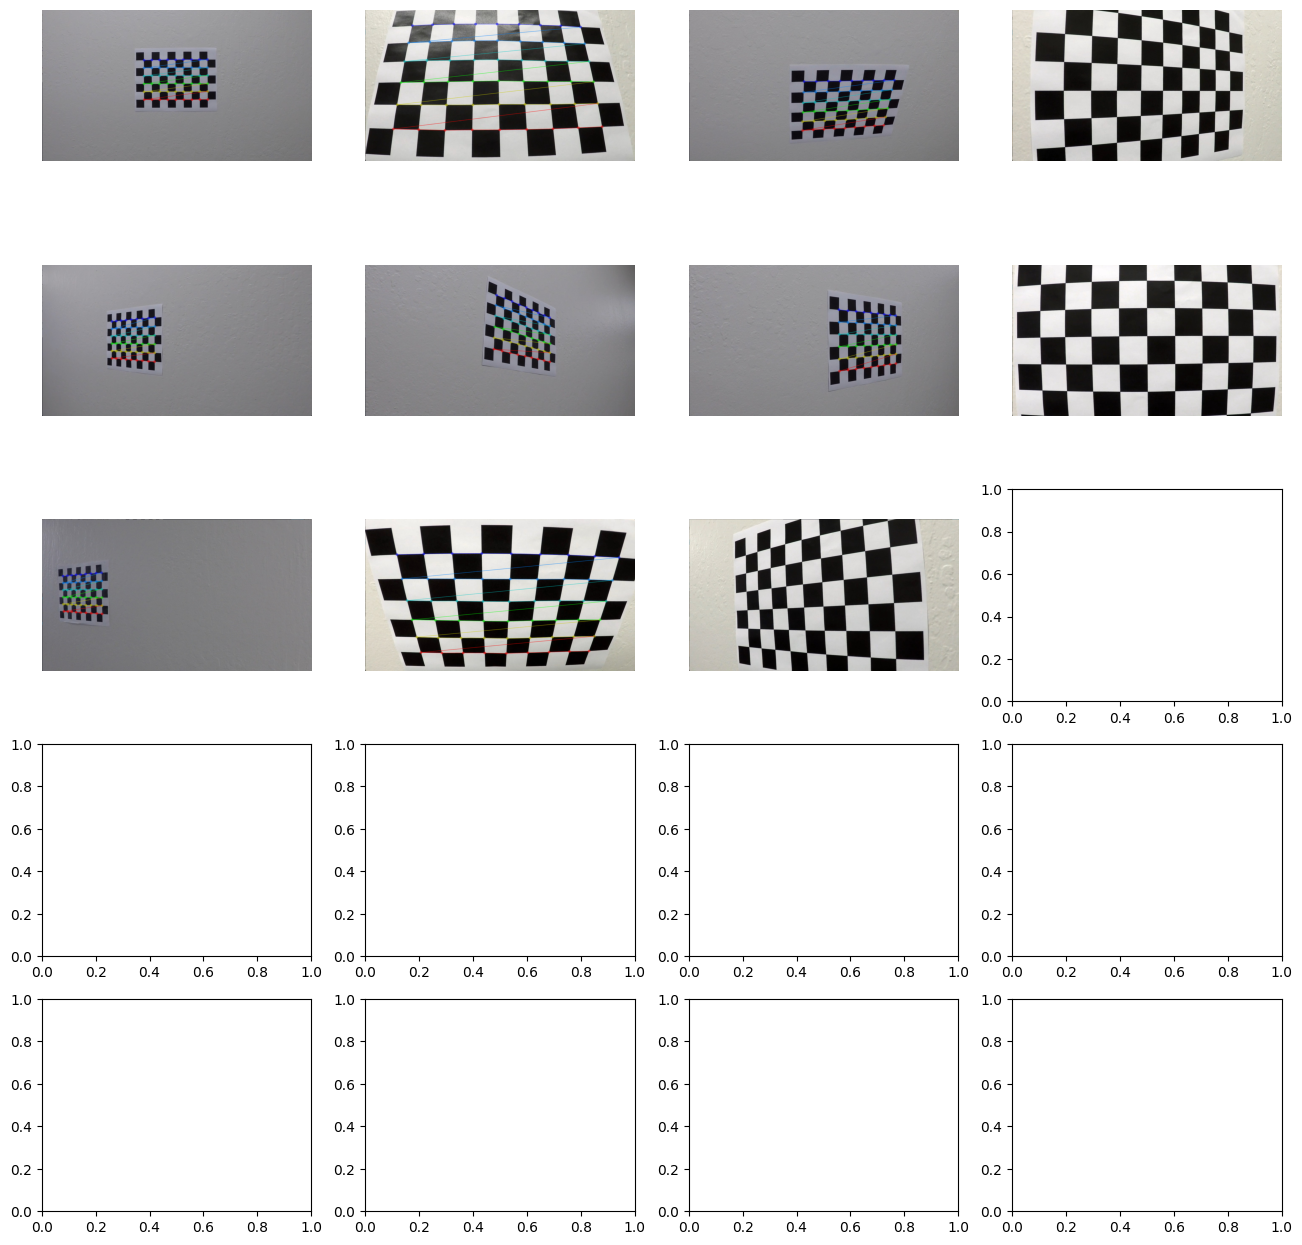

In [14]:
# Draw subplots dynamically
fig, axs = plt.subplots(5,4, figsize=(16, 16))
axs = axs.ravel()

for idx, img in enumerate(camera_cal_imgs):
    res_img = find_and_draw_chessboard(img)        
    axs[idx].axis('off')
    axs[idx].imshow(res_img)

In [17]:
#cache an image to further reuse
sample_img = mpimg.imread("canera_cal/calibration1.jpg")
#cache image size to further reuse
img_size = sample_img.shape[:2]

# Do Camera calibration given objects' points and images' points
# mtx - camera calibrated matrix
# dist - distortion cofficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size, None, None)

# Save the Camera calibration results for later use
dist_pickle = {"mtx": mtx, "dist": dist}
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

#### Distortion correction

Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that you can get correct and useful information out of them.

In [18]:
def undistort(img):
    """
    This is used to undistort distortion images by using camera calibration matrix and distortion cofficients
    
    :param img - Input image
    :return - undistort image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

In [19]:
def undistort_image(img):
    """
    This is used to visualize distortion corrected images with the original image.
    :param sample_img:
    :param cmatrix:
    :param distc:
    :return:
    """
    udistord_img = undistort(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(udistord_img)
    ax2.set_title('Undistorted Image', fontsize=18)
    # this can be used
    return udistord_img



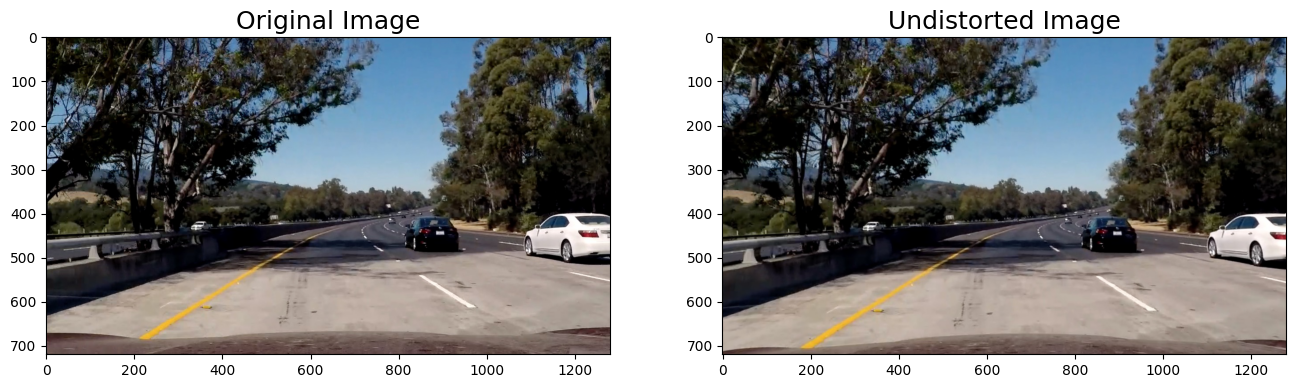

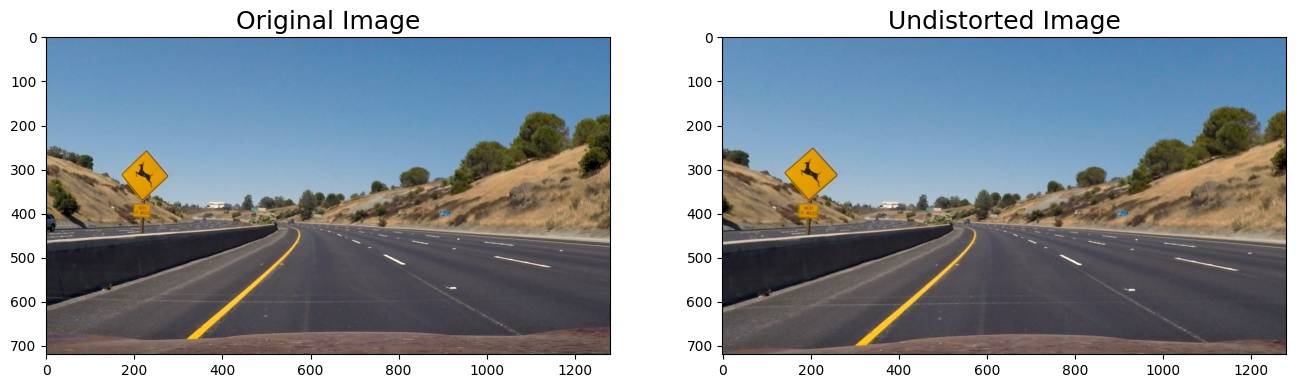

In [20]:
test_images = [mpimg.imread(path) for path in glob.glob("/content/test/*")]

#undistord images
undistort_images = list(map(lambda img: undistort_image(img), test_images[:2]))

### Perspective transformation

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.

In [21]:
height, width = test_images[0].shape[:2]

# These source and destination points can be captured by reading an image using OpenCV cv2.imshow() function and by 
# pointing mouse pointer for target coordinates. An utility test file can be found from utils folder 

# source points
p1 = (575, 465)
p2 = (705, 465)
p3 = (255, 685)
p4 = (1050, 685)
line_color = (0, 255, 0) # Green

# destination points
pd1 = (450, 0)
pd2 = (width - 450, 0)
pd3 = (450, height)
pd4 = (width - 450, height)

In [22]:
def draw_polygon_on_image(img, line_color=(0, 255,0)):
    """
    This is used to draw a polygon on input image 
    
    :param img: Distortion corrected image
    :param line-color -
    :return: Same image with a drawn polygon by using selected image coordinatations
    """
    cv2.line(img, p1, p2, line_color, 3)
    cv2.line(img, p2, p4, line_color, 3)
    cv2.line(img, p4, p3, line_color, 3)
    cv2.line(img, p3, p1, line_color, 3)

    return  img

In [23]:
# define source and destination points for tranform
src = np.float32([p1, p2, p3, p4])
dst = np.float32([pd1, pd2, pd3, pd4])

def unwarp(img, source=src, desctination=dst):
    """
    This is used to select a region from a given undistortion image as bird eye perspective.
    
    :param img - Distortion corrected image
    :param src - source 
    :param dst - destination
    :return - warped image, transform matrix, and inverse
    """
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(source, desctination)
    Minv = cv2.getPerspectiveTransform(desctination, source)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [24]:
# Visualize undistortion images and unwaperd images
def visualize_warped_images(img):
    """
    This is an utility function to visualize both undistortion image and unwarped image
    
    :param img - An undistortion image
    :return - Unwarped image that can be reused
    """
    # Apply unwarp for raw image
    unwarped, _, _ = unwarp(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,16))
    img = draw_polygon_on_image(img)
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=18)
    ax2.imshow(unwarped)
    ax2.set_title('Unwarped Image', fontsize=18)
    
    # unwarped image
    return unwarped

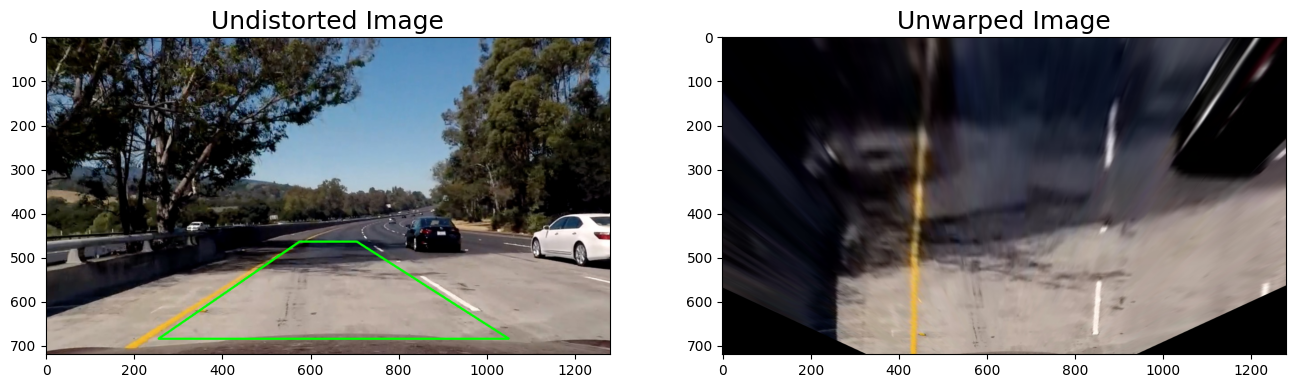

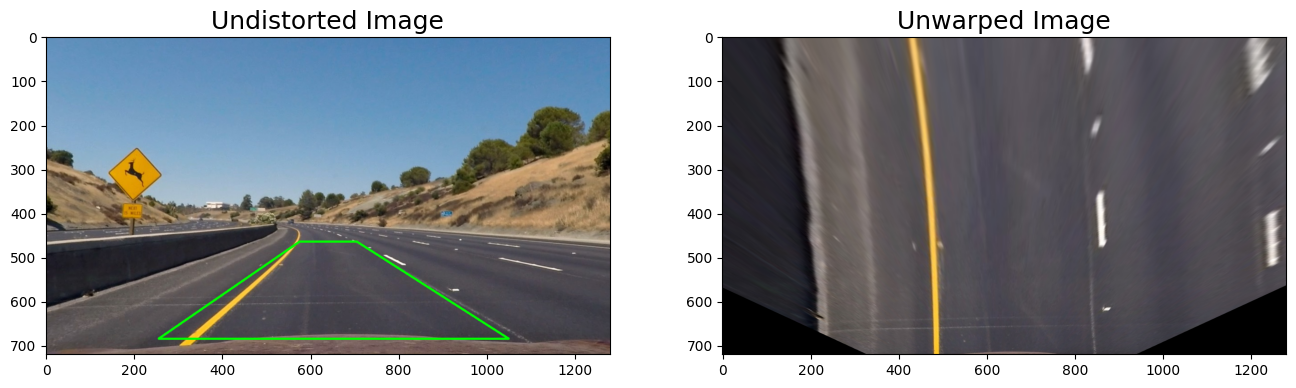

In [25]:
# Apply unwarp to get perspectives from test images
warped_images = list(map(lambda img: visualize_warped_images(img), undistort_images))